In [1]:
import pandas as pd
import seaborn as sns

In [2]:
# Import dataset
columns = ['Input', 'Sentiment']
df_train = pd.read_csv('../data/emotions-nlp/train.txt', header=None, sep=';', names=columns, encoding='utf-8')
df_test = pd.read_csv('../data/emotions-nlp/test.txt', header=None, sep=';', names=columns, encoding='utf-8')
df_val = pd.read_csv('../data/emotions-nlp/val.txt', header=None, sep=';', names=columns, encoding='utf-8')

# Dataset Balancing

In [3]:
# Check data distribution
import matplotlib.pyplot as plt

def plot_emotion_counts(df_train, df_test, df_val):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    sns.countplot(x=df_train.Sentiment.sort_values(), ax=ax[0])
    ax[0].set_title("Training dataset")

    sns.countplot(x=df_test.Sentiment.sort_values(), ax=ax[1])
    ax[1].set_title("Test dataset")

    sns.countplot(x=df_val.Sentiment.sort_values(), ax=ax[2])
    ax[2].set_title("Validation dataset")

    plt.show()

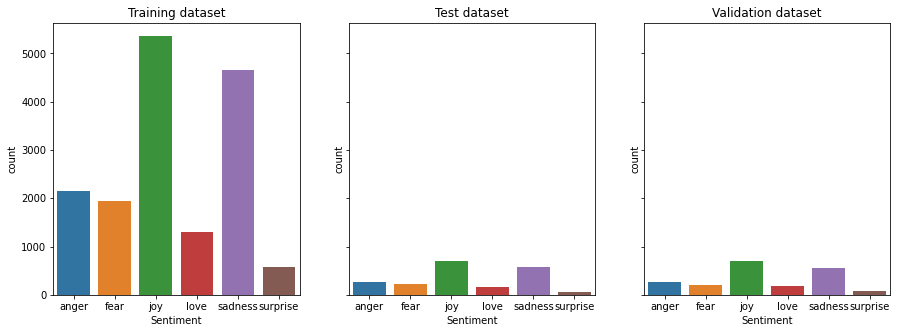

In [4]:
plot_emotion_counts(df_train, df_test, df_val)

In [5]:
# Balance dataset by upsampling the minority class (surprise)
from sklearn.utils import resample

def upsample(minority, majority, class_column):
    # Upsample minority class to average size of the majority classes
    majority_class_count = len(majority[class_column].unique())
    average_class_size = int(len(majority) / majority_class_count)

    minority_upsampled = resample(minority, replace=True, n_samples=average_class_size, random_state=42)
    df_upsampled = pd.concat([majority, minority_upsampled])
    return df_upsampled

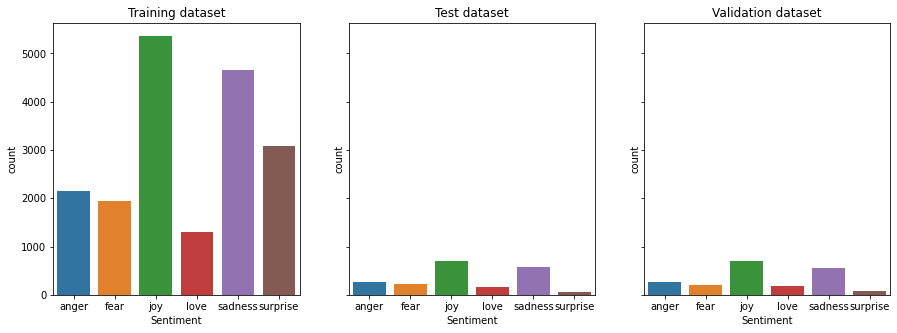

In [6]:
# Balance training dataset
df_train_majority = df_train[df_train.Sentiment == 'surprise']
df_train_minority = df_train[df_train.Sentiment != 'surprise']
df_train_upsampled = upsample(df_train_majority, df_train_minority, 'Sentiment')
plot_emotion_counts(df_train_upsampled, df_test, df_val)

# Text Cleaning

In [7]:
import re, nltk, string

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

def remove_stopwords(text):
    text = text.split(' ')
    return " ".join([word for word in text if word not in stopwords])

def stem(text):
    text = text.split(' ')
    return " ".join([ps.stem(word) for word in text])

def text_cleaning(df, column):
    df[column] = df[column].apply(lambda x: str(x).lower()) # Convert to lowercase
    df[column] = df[column].apply(lambda x: re.sub('\s+', ' ', x)) # Remove extra spaces
    df[column] = df[column].apply(lambda x: re.sub("[^-9A-Za-z ]", " ", x)) # Remove punctuation
    df[column] = df[column].apply(remove_stopwords)
    return df

In [8]:
text_cleaning(df_train, 'Input') # Need to upsample original training set to build vocab
text_cleaning(df_train_upsampled, 'Input')
text_cleaning(df_test, 'Input')
text_cleaning(df_val, 'Input')
df_train.head(10)

,Input,Sentiment
0,didnt feel humiliated,sadness
1,go feeling hopeless damned hopeful around some...,sadness
2,im grabbing minute post feel greedy wrong,anger
3,ever feeling nostalgic fireplace know still pr...,love
4,feeling grouchy,anger
5,ive feeling little burdened lately wasnt sure,sadness
6,ive taking milligrams times recommended amount...,surprise
7,feel confused life teenager jaded year old man,fear
8,petronas years feel petronas performed well ma...,joy
9,feel romantic,love


# Create vocabulary

In [9]:
from torchtext.data.utils import get_tokenizer
from collections import Counter, OrderedDict
from torchtext.vocab import vocab

In [10]:
EMBEDDING_DIM=50
VOCAB_SIZE=20000

# Load tokenizer
tokenizer = get_tokenizer('spacy', language='en')

# Get all text
all_text = pd.concat([df_train.Input, df_test.Input, df_val.Input])

# Build vocab
counter = Counter()
for input in all_text:
    counter.update(tokenizer(input))

ordered_dict = OrderedDict(counter.most_common()[:VOCAB_SIZE])
vocab = vocab(ordered_dict)

# insert special tokens and set default index to 'unknown'
vocab.insert_token('<PAD>', 0)
vocab.insert_token('<UNK>', 1)
vocab.set_default_index(1)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


# Build up train/test/val dataset

In [11]:
# Label encoding
emotion_labels = df_train_upsampled.Sentiment.unique()
label_to_ids = {}
for id in range(len(emotion_labels)):
    label = emotion_labels[id]
    label_to_ids[label] = id
label_to_ids

{'sadness': 0, 'anger': 1, 'love': 2, 'fear': 3, 'joy': 4, 'surprise': 5}

In [12]:
from torch.nn.utils.rnn import pad_sequence
import torch
from torch.utils.data import DataLoader, Dataset
from torchtext.data.functional import to_map_style_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def process_text(text):
    return vocab(tokenizer(text))

def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for (_text, _label) in batch:
        label_list.append(label_to_ids[_label])
        processed_text = torch.tensor(process_text(_text), dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(processed_text.size(0) - 1)

    # label must be in the same size as target
    label_list = torch.tensor(label_list, dtype=torch.float)[:,None]

    # Ensure all text is the same length
    text_list = pad_sequence(text_list, batch_first=True)

    # Create mask
    lengths = torch.LongTensor(lengths)

    seq_len = len(text_list[0])
    batch_size = len(batch)
    mask = torch.zeros(batch_size, seq_len, 1)

    rows = torch.arange(0, batch_size).long()
    mask[rows, lengths, :] = 1

    return label_list.to(device), text_list.to(device), mask.to(device)


In [13]:
class EmotionDataset(Dataset):
    def __init__(self, dataframe) -> None:
        self.dataframe = dataframe

    def __len__(self) -> int:
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        return row

In [14]:
train_dataset = EmotionDataset(df_train_upsampled)
test_dataset = EmotionDataset(df_test)
val_dataset = EmotionDataset(df_val)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True, collate_fn=collate_batch)

# Create embedding vectors from GloVe

In [15]:
import torchtext as text

# load glove embeddings
vec = text.vocab.GloVe(name='6B', dim=50)

# create the embedding matrix, a torch tensor in the shape (num_words+1, embedding_dim)
word_emb = vec.get_vecs_by_tokens(vocab.get_itos())

# Define NN

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BiLSTM(nn.Module):
    def __init__(self, word_vec, embed_dim) -> None:
        super().__init__()
        self.embedding = nn.Embedding(*(word_vec.size())).from_pretrained(word_vec, freeze=False) # Embedding Layer
        self.lstm = nn.LSTM(embed_dim, 200, num_layers=2, bidirectional=True, batch_first=True) # LSTM Layer
        self.fc = nn.Linear(2 * 200, 1)

    def forward(self, text, lengths):
        embedded = self.embedding(text) # (batch_size, seq_len, emb_size)
        lstm_out, _ = self.lstm(embedded) # (batch_size, seq_len, output_size)

        batch_size, seq_len, output_size = lstm_out.size()
        mask = lengths.expand(-1, seq_len, output_size)
        out = lstm_out * mask
        out = torch.sum(out, dim=1)
        out = self.fc(out)
        out = F.softmax(out, dim=1)

        return out

# Model training

In [17]:
import numpy as np

def plot_progress(accuracies, epochs):
    plt.figure(figsize=(20, 5))
    plt.plot(accuracies)
    plt.xticks(np.arange(0, epochs))
    plt.title('Accuracy')
    plt.show()

def train(model, trainloader, criterion, optimizer, epochs=10):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 50
    
    accuracies = []
    for _ in range(epochs):
        for idx, (label, text, lengths) in enumerate(trainloader):
            optimizer.zero_grad()
            predicted_label = model(text, lengths)
            loss = criterion(predicted_label, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            
            total_acc += torch.eq(predicted_label, label).sum().item()
            total_count += label.size(0)

            if idx % log_interval == 0 and idx > 0:
                accuracies.append(100 * total_acc / total_count)
                total_acc, total_count = 0, 0
        
    plot_progress(accuracies, epochs)

def evaluate(model, testloader, criterion):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, lengths) in enumerate(testloader):
            predicted_label = model(text, lengths)
            loss = criterion(predicted_label, label)
            total_acc += torch.eq(predicted_label, label).sum().item()
            total_count += label.size(0)
            
    return 100 * total_acc/total_count

In [18]:
model = BiLSTM(word_vec=word_emb, embed_dim=EMBEDDING_DIM).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

train(model, train_dataloader, criterion, optimizer, 30)

KeyboardInterrupt: 

In [ ]:
accu_test = evaluate(model, test_dataloader, criterion)
print('test accuracy {:8.2f}%'.format(accu_test))

test accuracy    13.75%
